# Dummy example

I want to learn a function, that preserves the topology the latent space

In [1]:
import gudhi
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch

from gudhi.wasserstein import wasserstein_distance
from torch.optim.lr_scheduler import LambdaLR

2024-02-16 10:02:01.913727: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-16 10:02:01.959473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 10:02:01.959506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 10:02:01.960677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 10:02:01.968626: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def wasserstein_based_loss(features_1, features_2):
    rips = gudhi.RipsComplex(points=features_1, max_edge_length=0.5)
    rips_1 = gudhi.RipsComplex(points=features_2, max_edge_length=0.5)
    # for the first Point cloud
    st = rips.create_simplex_tree(max_dimension=2)
    st.compute_persistence()
    i = st.flag_persistence_generators()
    if len(i[1]) > 0:
        i1 = torch.tensor(i[1][0])  # pytorch sometimes interprets it as a tuple otherwise
    else:
        i1 = torch.empty((0, 4), dtype=int)
    # for the seconds Point cloud
    st_1 = rips_1.create_simplex_tree(max_dimension=2)
    st_1.compute_persistence()
    i_1 = st_1.flag_persistence_generators()
    if len(i_1[1]) > 0:
        i1_1 = torch.tensor(i_1[1][0])
    else:
        i1_1 = torch.empty((0, 4), dtype=int)
        
    # Same as the finite part of st.persistence_intervals_in_dimension(1), but differentiable
    diag = torch.norm(features_1[i1[:, (0, 2)]] - features_1[i1[:, (1, 3)]], dim=-1)
    diag1 = torch.norm(features_2[i1_1[:, (0, 2)]] - features_2[i1_1[:, (1, 3)]], dim=-1)

    
    wasser = wasserstein_distance(diag, 
                                  diag1, 
                                  order=1, 
                                  enable_autodiff=True)
    print("wasser", wasser)
    return wasser


In [3]:
network = nn.Sequential(
    nn.Linear(200, 10),
    nn.ReLU(),)


wasser tensor(0.2957, grad_fn=<SumBackward0>)


/home/jmordacq/miniconda3/envs/difftda/lib/python3.9/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


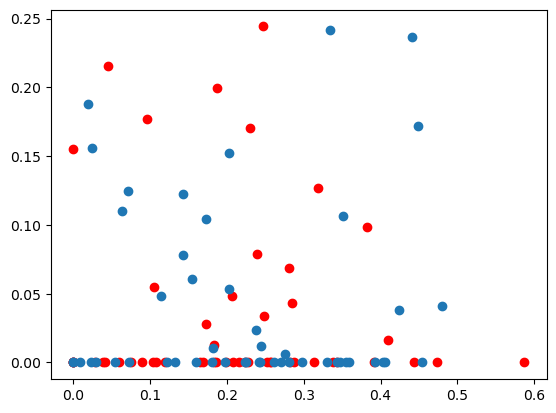

wasser tensor(0.3733, grad_fn=<SumBackward0>)
wasser tensor(0.1602, grad_fn=<SumBackward0>)


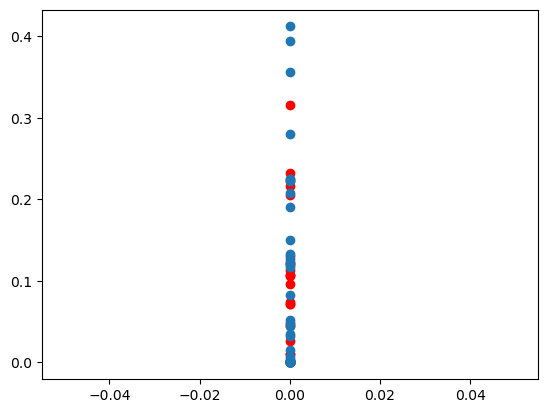

wasser tensor(0.2142, grad_fn=<SumBackward0>)
wasser tensor(0.2274, grad_fn=<SumBackward0>)


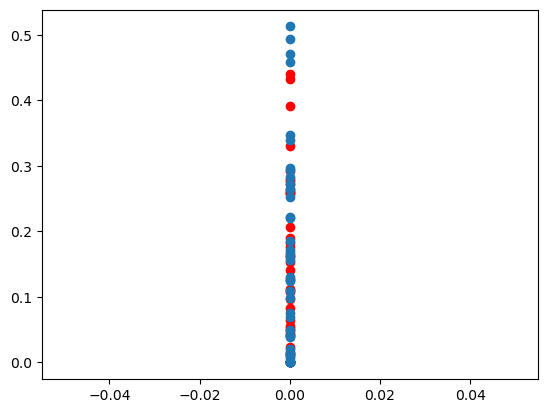

wasser tensor(0.1152, grad_fn=<SumBackward0>)
wasser tensor(0.1579, grad_fn=<SumBackward0>)


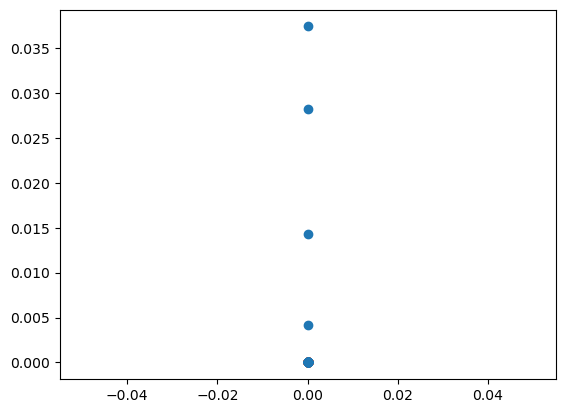

wasser tensor(0.1451, grad_fn=<SumBackward0>)
wasser tensor(0.1387, grad_fn=<SumBackward0>)


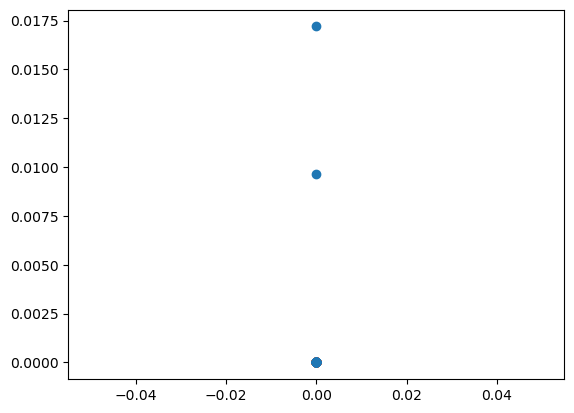

wasser tensor(0.1709, grad_fn=<SumBackward0>)
wasser tensor(0.1020, grad_fn=<SumBackward0>)


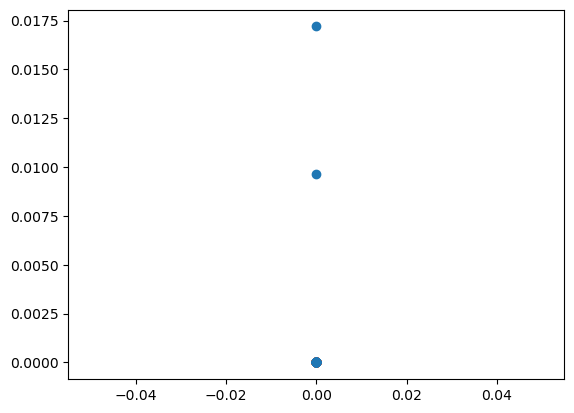

wasser tensor(0.1738, grad_fn=<SumBackward0>)
wasser tensor(0.1232, grad_fn=<SumBackward0>)


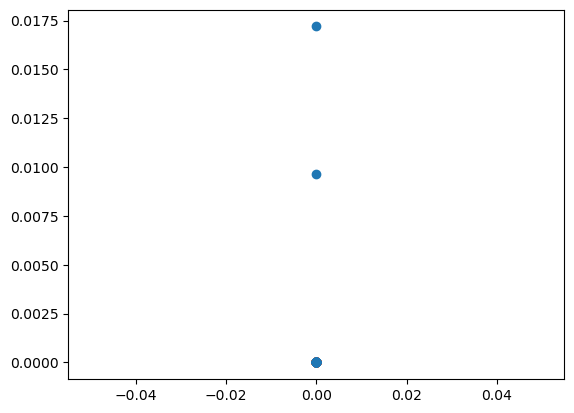

wasser tensor(0.1057, grad_fn=<SumBackward0>)
wasser tensor(0.1697, grad_fn=<SumBackward0>)


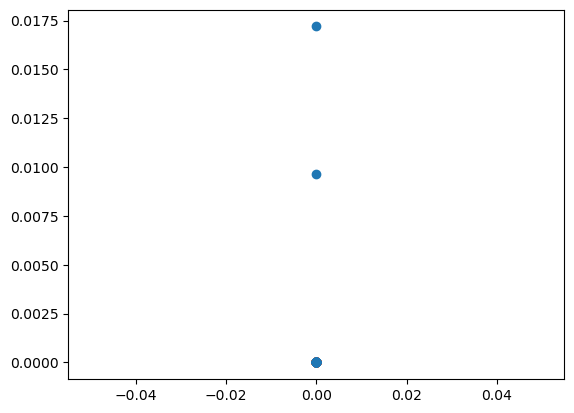

wasser tensor(0.1114, grad_fn=<SumBackward0>)
wasser tensor(0.1692, grad_fn=<SumBackward0>)


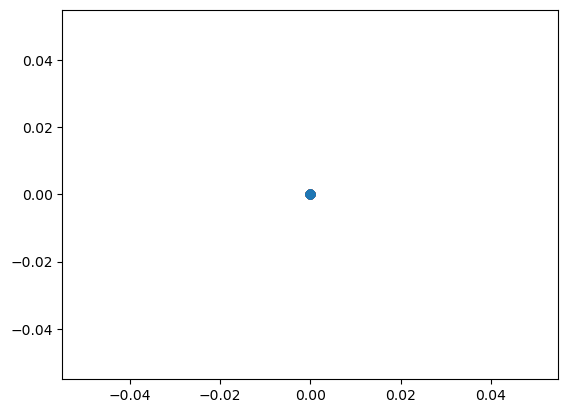

wasser tensor(0.1418, grad_fn=<SumBackward0>)
wasser tensor(0.1614, grad_fn=<SumBackward0>)


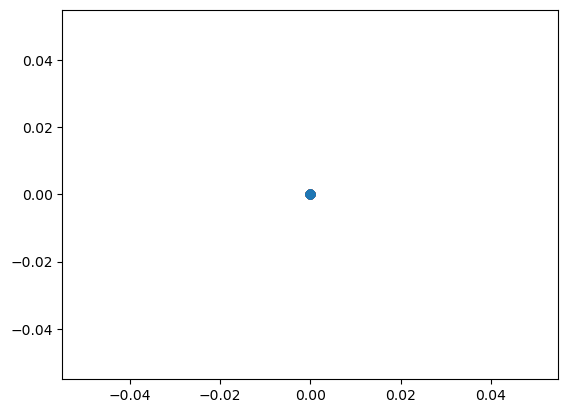

wasser tensor(0.1364, grad_fn=<SumBackward0>)


In [4]:
X = torch.tensor(np.random.rand(50, 200), dtype=torch.float32)
Y = torch.tensor(np.random.rand(50, 200), dtype=torch.float32)

losses = []
# learn a latent space where the Wasserstein distance is minimized between the two point clouds

opt = torch.optim.SGD(network.parameters(), lr=1)
scheduler = LambdaLR(opt,[lambda epoch: 10./(10+epoch)])
for idx in range(20):
    view_1 = network(X)
    view_2 = network(Y)
    opt.zero_grad() 
    loss = wasserstein_based_loss(view_1, view_2)
    loss.backward()
    losses.append(loss.item())
    opt.step()
    # Draw every 100 epochs
    if idx % 2 == 0:
        latent_X = view_1.detach().numpy()
        latent_Y = view_2.detach().numpy()
        plt.scatter(latent_X[:, 0], latent_X[:, 1], c="r")
        plt.scatter(latent_Y[:, 0], latent_Y[:, 1])
        plt.show()


Text(0.5, 1.0, 'Wasserstein loss on persistence diagrams in the latent space')

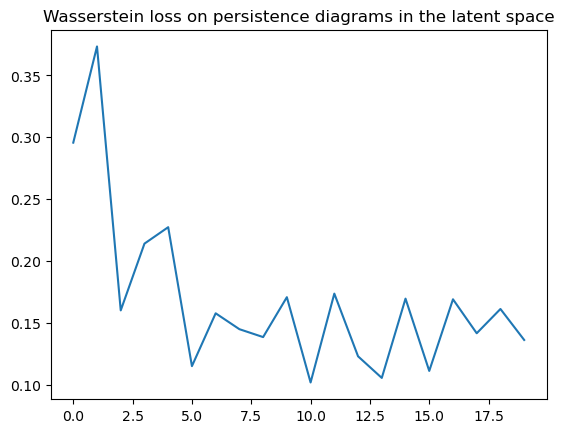

In [5]:
plt.plot(losses)
plt.title("Wasserstein loss on persistence diagrams in the latent space")